# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 47169,
  "iopub_port": 51513,
  "stdin_port": 42617,
  "control_port": 55895,
  "hb_port": 47297,
  "ip": "127.0.0.1",
  "key": "cd538a38-50f5d6c7fae30b40152fa7ab",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f68371f0-c567-45ec-8e39-f30f63edebf1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/test_new/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'emu', 'mumu',  
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.1)

In [3]:
# generate toy data 
params = fit_data._parameters
params_pre = fit_data.get_params_init().values

# test systematic uncertainties
#pval, perr = params['val_init'].values, params['err_init'].values
#perr[:4] = [0.001, 0.001, 0.001, 0.007]
#prand = pval[:4] + np.random.randn(4, ntoys).T*perr[:4] 

beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                [(0.104, 0.114), (0.104, 0.114), (0.104, 0.114)], 
                                [10, 10, 10]
                                )
scan_vals = np.array(beta_scan_vals.get_scan_vals()[0])
beta_h = np.transpose([1 - np.sum(scan_vals, axis=1)])
scan_vals = np.hstack((scan_vals, beta_h, np.outer(np.ones(scan_vals.shape[0]), params_pre[4:])))

In [ ]:
# fit toy data
def simplified_objective(p, data, plen):
    p = np.concatenate([p[:plen], params_pre[plen:]])
    return fit_data.objective(p, data)

results = []
sv_accept = []
nparams = params.shape[0] #fit_data._npoi + fit_data._nnorm
step_sizes = 0.001*params['err_init'][:nparams]
step_sizes[:4] = 4*[1e-6,]
min_options = dict(maxiter=1000, ftol=1e-6, disp=False)
for sv in tqdm_notebook(scan_vals):
    sample = {cat:fit_data.mixture_model(sv, cat) for cat in fit_data._model_data.keys()}
    pinit  = params_pre[:nparams]
    result = minimize(simplified_objective, pinit,
                      method = 'SLSQP', 
                      options = min_options,
                      args = (sample, nparams)
                     )
    is_success = result.success
    pinit=result.x
    
    print(fit_data.objective(params_pre, sample), fit_data.objective(sv, sample), result.fun, result.x[:4] - sv[:4])
    if result.success:
        results.append(result.x)
        sv_accept.append(sv)
    else:
        print(sv[:nparams])
        print(result)
        
results = np.array(results)
sv_accept = np.array(sv_accept)

1762.0795774739613 0.0 0.0037469654508077714 [-5.7914e-06 -3.3917e-06  1.2812e-06  7.8935e-06]
1706.8692854776423 0.0 0.0017659039658454293 [ 4.8263e-06  3.8079e-07  4.6240e-06 -9.8373e-06]
1656.248932085488 0.0 0.00796041148838083 [ 6.2394e-06  1.7329e-06  3.8051e-07 -8.3592e-06]
1610.2076247905434 0.0 0.0016965220210376601 [-4.8767e-06  1.0404e-06 -1.5925e-06  5.4210e-06]
1568.7346860729695 0.0 0.001407828121875951 [-3.7195e-07 -1.1973e-06  1.7731e-06 -2.1123e-07]
1531.8196486908287 0.0 0.003938129113465543 [ 1.0725e-06 -1.3951e-06 -7.9446e-06  8.2619e-06]
1499.4522511308592 0.0 0.0027263023995217346 [-3.1786e-06 -2.5943e-06 -8.3261e-06  1.4092e-05]
1471.6224331917672 0.0 0.0029462588142074673 [-5.1118e-06 -6.2534e-06 -1.0459e-05  2.1816e-05]
1448.3203316907889 0.0 0.002555239929200372 [ 9.4867e-06  7.6792e-06  6.4721e-06 -2.3645e-05]
1429.536276313799 0.0 0.006041156241539289 [ 9.0626e-06  7.2454e-06  1.4071e-05 -3.0387e-05]
1291.084655919051 0.0 0.002388512968862844 [-3.7150e-06  2

955.9937689017423 0.0 638468.166939567 [-0.3004  0.0293  0.6252 -0.354 ]
[0.104  0.1107 0.1129 0.6724 0.1783 0.1741 0.6476 1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.    ]
     fun: 638468.166939567
     jac: array([ 9.2864e+07,  8.1033e+07,  8.5678e+07,  8.5179e+07,  2.6998e+06,
       -1.2779e+06, -9.0216e+05, -1.2017e+07,  4.8420e+02, -5.0560e+04,
        4.1768e+04, -3.8365e+05,  1.8156e+01,  2.0595e+03,  0.0000e+00,
        6.1431e+04,  2.3944e+05, -1.0550e+06,  1.7315e+02, -1.2963e+02,
        1.3061e+02, -4.1797e+00,  1.

564.7103834477548 0.0 0.0018924553045824 [-4.4452e-06 -1.4354e-06 -1.6981e-07  6.0380e-06]
536.877492679956 0.0 0.0017458716757490574 [-4.4291e-06 -9.5332e-07 -3.1828e-06  8.5610e-06]
513.6755940349574 0.0 0.004256958004597436 [ 2.7550e-06  2.9456e-06 -1.1714e-06 -4.5574e-06]
495.093955983334 0.0 0.0016591629013005215 [-1.4967e-06 -2.2791e-06 -4.1537e-06  7.9234e-06]
481.1220576385472 0.0 0.002754415793902592 [-2.6080e-06  2.0604e-06 -1.1163e-05  1.1698e-05]
471.7495842306939 0.0 0.0016235715915828924 [ 5.7702e-07 -1.1055e-06  1.5788e-06 -1.0527e-06]
466.9664227117746 0.0 0.001811798601113323 [ 8.7926e-06  5.7213e-06  4.2005e-06 -1.8725e-05]
466.7626574991155 0.0 0.002920899015143971 [-1.2401e-06  4.1572e-06  6.7571e-08 -2.9926e-06]
441.3259894092724 0.0 0.00416218967108302 [ 7.9624e-07 -7.1179e-06 -9.5626e-06  1.5877e-05]
410.8800471059801 0.0 0.006080976517968453 [ 3.8484e-06 -8.0710e-06  1.8537e-06  2.3680e-06]
385.10986151515874 0.0 0.0036676201282740896 [-7.7090e-06  9.1030e-07 -3

727.7880444566244 0.0 0.004490254756173879 [ 4.5615e-07  7.3325e-07 -6.4990e-07 -5.5084e-07]
688.3717764676885 0.0 0.0021204920618731844 [-6.8209e-07 -3.1074e-06 -4.5190e-06  8.2989e-06]
653.6047241887459 0.0 0.0027292068441921676 [-1.8217e-06  1.0884e-06  7.9466e-07 -7.1757e-08]
623.4757461869426 0.0 0.0022622937749784194 [-8.0136e-06  2.9627e-06 -8.3853e-06  1.3434e-05]
597.973920594417 0.0 0.0027063492357648888 [ 1.2944e-06  1.3898e-06  7.3232e-06 -1.0008e-05]
577.0885403114072 0.0 0.0017947191188289354 [ 5.3806e-06 -1.7854e-07  1.4673e-06 -6.6774e-06]
560.8091083442064 0.0 0.0023434516363463466 [-4.5634e-06 -4.5091e-07 -2.0063e-06  7.0071e-06]
549.1253332900172 0.0 0.0020903503763271573 [-2.5017e-07 -2.4661e-06  2.7245e-07  2.4317e-06]
542.0271249517423 0.0 0.0019874901083866132 [ 1.7077e-06  2.9681e-06  1.3515e-06 -6.0384e-06]
539.5045900948155 0.0 0.0027395196952035533 [-4.2358e-07 -2.9502e-06  1.6019e-06  1.7585e-06]
407.89006430418647 0.0 0.0016348693657362897 [-5.8857e-07  8.3

470.4619125505594 0.0 0.0013736650075421844 [-8.2461e-07  1.4264e-06 -5.5612e-06  4.9537e-06]
483.28788073478637 0.0 0.003560743426595985 [ 2.7236e-06  1.2492e-07 -3.2684e-06  4.1355e-07]
500.8320340448708 0.0 0.002313041343278886 [-3.6170e-06 -3.6240e-06 -1.4984e-06  8.7306e-06]
523.0836106584667 0.0 0.004777624418394883 [ 7.1784e-06 -1.2173e-06  1.4573e-06 -7.4270e-06]
550.03205874199 0.0 0.0023474957715466788 [-6.1152e-06 -1.9975e-06 -6.6654e-06  1.4772e-05]
581.6670320064052 0.0 0.0019728265446757698 [ 6.4178e-06 -1.5751e-06  1.0504e-05 -1.5356e-05]
810.4919938289838 0.0 0.0033074577292873074 [-1.6107e-06  4.4764e-06 -8.7450e-06  5.8754e-06]
810.7620554826378 0.0 0.0025161178920453903 [-3.8592e-06  2.6599e-06 -1.0084e-06  2.2015e-06]
815.8189387137655 0.0 0.0031859512821458004 [ 4.5621e-06 -3.0666e-08 -2.2760e-06 -2.2644e-06]
825.6508911805004 0.0 0.0027281117171183344 [-9.7418e-06 -1.6200e-06 -2.5181e-05  3.6533e-05]
840.2463916886977 0.0 0.0026585960132406447 [-5.8370e-06 -4.9186

52.2961615705198 0.0 0.0037357787545241727 [ 8.4859e-07  6.1619e-06 -6.2182e-06 -7.9562e-07]
70.53346507773234 0.0 0.0024299746689572053 [-1.3758e-06  5.4819e-06 -1.3386e-05  9.2652e-06]
93.4305928026883 0.0 0.003937355143749655 [ 3.2505e-06  2.5843e-07 -1.1062e-05  7.5415e-06]
146.12261780779033 0.0 0.004071846525334866 [ 5.0792e-06  9.3696e-06 -1.5330e-05  8.8547e-07]
138.0620861983338 0.0 0.002084293350941808 [ 1.0863e-05 -5.8831e-06  9.3461e-06 -1.4339e-05]
134.76046003193025 0.0 0.0035842956211329267 [-1.2985e-05 -5.2749e-06 -1.1046e-05  2.9302e-05]
136.20611792062334 0.0 0.0018795223435325388 [-3.9899e-06 -4.4560e-06 -8.3106e-06  1.6762e-05]
142.38766708744737 0.0 0.002777561885922784 [ 3.8308e-06 -4.4493e-06  7.2235e-06 -6.6176e-06]
153.29393835774607 0.0 0.0033677466626015344 [ 1.1602e-06  5.0893e-06 -3.8624e-07 -5.8632e-06]
168.91398129918133 0.0 0.0018462316644863328 [ 1.6656e-06  6.4417e-07  2.9233e-06 -5.2412e-06]
189.23705951135366 0.0 0.0032359582456674154 [-1.3107e-06  8

30.731688412769657 0.0 0.0022140530272610035 [ 2.2572e-09 -2.4803e-06  1.5131e-06  9.5786e-07]
37.362652458350155 0.0 0.0028259297993225487 [ 9.1692e-06 -5.7678e-07  3.9192e-06 -1.2521e-05]
48.67017151357645 0.0 0.0030409647829531677 [-8.4815e-06  2.7662e-06 -3.1938e-06  8.9062e-06]
64.64383499473428 0.0 0.0027533836968892445 [ 3.2701e-06 -9.2872e-07 -6.7701e-06  4.4227e-06]
85.2734351012007 0.0 0.0013186070894423308 [ 2.6552e-06 -3.0279e-06  2.9934e-06 -2.6339e-06]
33.88904388074979 0.0 0.0020652981975306487 [-1.7049e-06 -4.8533e-06 -2.2803e-07  6.7844e-06]
23.712727308251182 0.0 0.0036840194277418 [-4.2469e-06  9.7515e-07 -4.0254e-06  7.2960e-06]
18.291074960076273 0.0 0.0026268343421917387 [-1.2891e-06  1.2932e-06 -8.5535e-06  8.5355e-06]
17.61249224742075 0.0 0.002006271873063553 [ 4.0940e-07  3.5992e-06  1.0925e-05 -1.4937e-05]
21.665612615731185 0.0 0.0014180531443291897 [-5.6102e-06 -2.3374e-06 -9.2077e-06  1.7143e-05]
30.439292554538326 0.0 0.0017048686256567985 [-3.9156e-06  8

245.8308557473802 0.0 0.0017773949022079551 [-2.1796e-06  1.3882e-06  3.3930e-06 -2.6028e-06]
240.61332983744097 0.0 0.004001259331411848 [-2.4813e-06  5.5874e-06  1.2557e-05 -1.5684e-05]
240.09010648209798 0.0 0.0011915759517445324 [-4.8365e-06 -4.0685e-06  4.6878e-06  4.2094e-06]
244.25037986798046 0.0 0.0020822460301555155 [ 5.0017e-06  5.7839e-06 -2.4369e-06 -8.3563e-06]
253.08355535283135 0.0 0.0022610503530945416 [ 9.9822e-07  2.2732e-06 -3.6358e-07 -2.9173e-06]
266.5792449515675 0.0 0.002914319052186066 [-7.0234e-06 -1.9220e-06  4.1521e-06  4.7809e-06]
284.7272629627514 0.0 0.0030588713513822756 [ 2.1929e-06  7.0464e-06 -1.9582e-05  1.0347e-05]
129.97147711076974 0.0 0.003042036536016267 [-2.1891e-06  3.1990e-06  1.7765e-06 -2.7963e-06]
117.46483588959134 0.0 5507394.14742927 [-0.104   0.0143 -0.9893  1.079 ]
[0.1096 0.1073 0.1051 0.678  0.1783 0.1741 0.6476 1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     0.     0.
 0.     0.     0.     0.     0.     0.

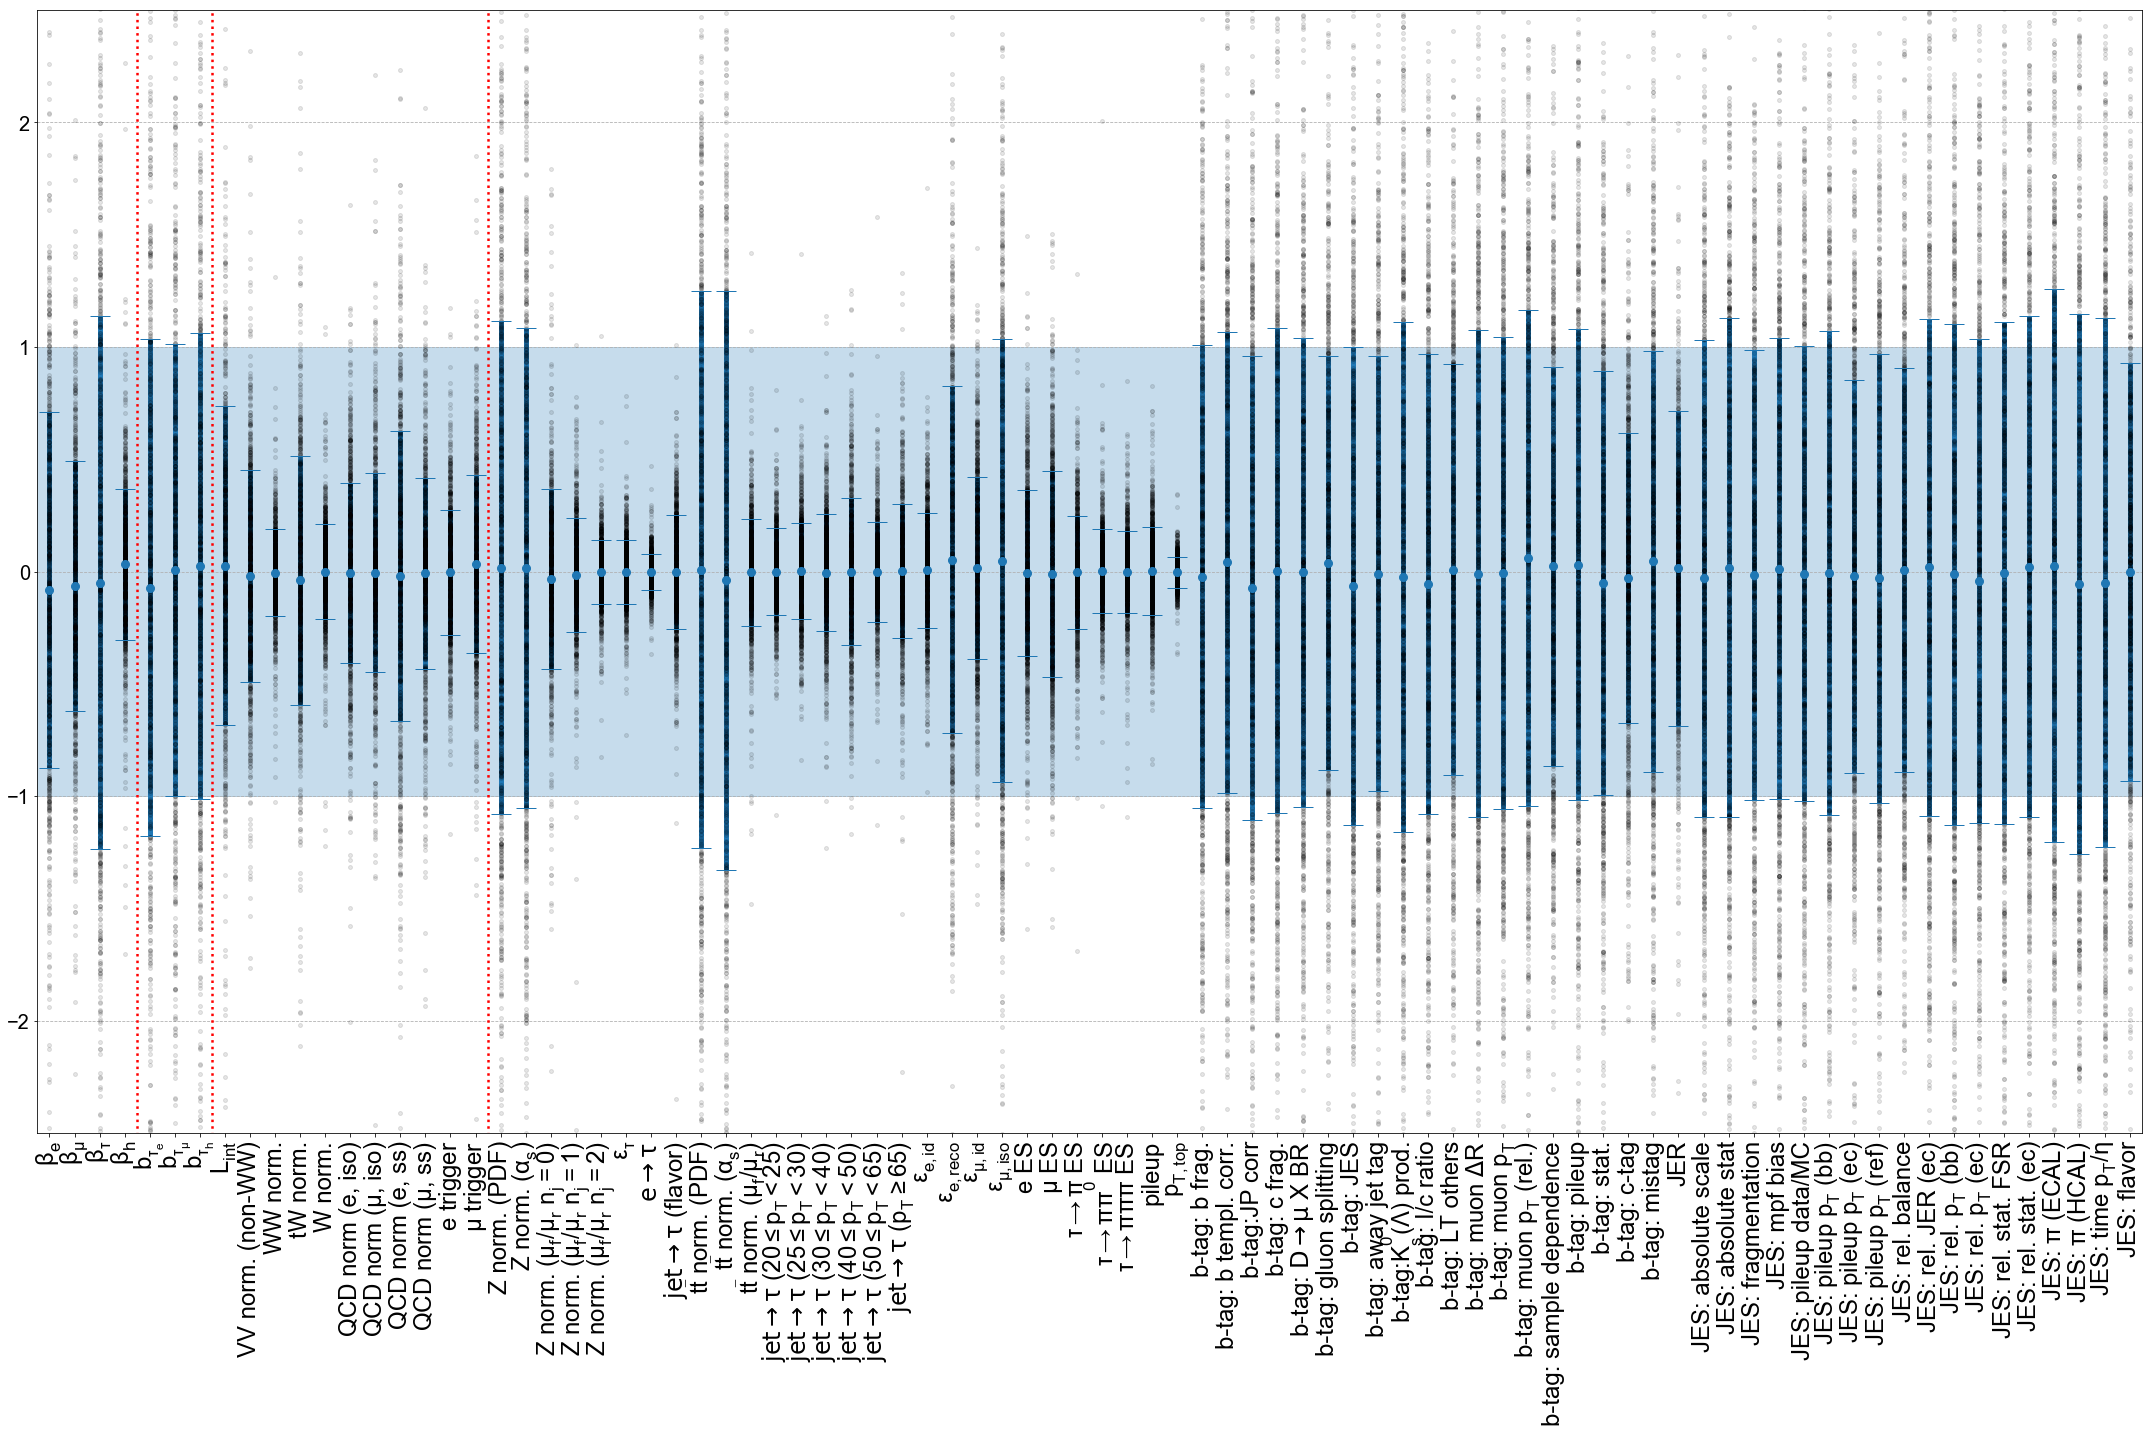

In [17]:
# make some plots

fig, ax = plt.subplots(1, 1, figsize=(30, 20), facecolor='white')

#calculate biases
diff = (results - sv_accept[:,:nparams])*1e2
diff[:,:4] /= 0.01*params['val_init'][:4].values/np.sqrt(2)
diff[:,4:] /= params['err_init'][4:].values
diff[:,4:7] *= 2

diff = np.array([d for d in diff if np.all((d > -10) & (d < 10))])

#plotting the results
xticks = np.outer(np.arange(nparams), np.ones(diff.shape[0])).T
ax.plot(xticks+1,  diff, 'ko', alpha=0.1, markersize=4)
#ax.boxplot(diff)
ax.errorbar(xticks[0,:]+1,  diff.mean(axis=0), diff.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.plot([4.5, 4.5], [-5, 5], 'r:')
ax.plot([7.5, 7.5], [-5, 5], 'r:')
ax.plot([7.5+fit_data._nnorm, 7.5+fit_data._nnorm], [-5, 5], 'r:')
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0,:]+1)
ax.set_xticklabels(params.label[:nparams], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_xlim(0.5, nparams+0.5)
#ax.set_xlim(0.5, 4.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')


plt.tight_layout()
plt.show()

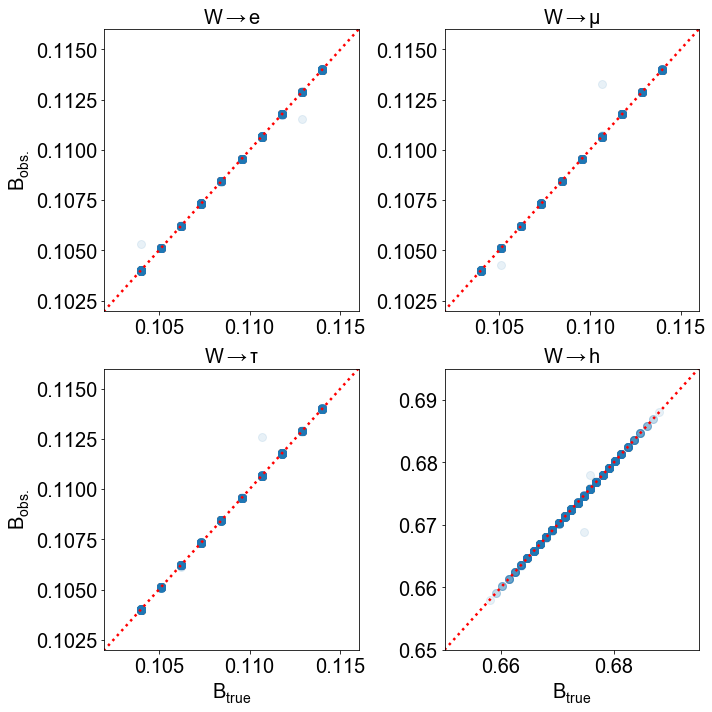

In [74]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=False, sharey=False)

mask = ((results[:,:3] > 0.09) & (results[:,:3] < 0.12)).all(axis=1)
beta_val = sv_accept[mask,:4]
beta_obs = results[mask,:4]

ax = axes[0][0]
ax.plot(beta_val[:,0], beta_obs[:,0], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.116)
ax.set_ylim(0.102, 0.116)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
ax.plot(beta_val[:,1], beta_obs[:,1], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.116)
ax.set_ylim(0.102, 0.116)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
ax.plot(beta_val[:,2], beta_obs[:,2], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.116)
ax.set_ylim(0.102, 0.116)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
ax.plot(beta_val[:,3], beta_obs[:,3], 'C0o', alpha=0.1)
ax.plot([0.65, 0.72], [0.65, 0.72], 'r:')
ax.set_xlim(0.65, 0.695)
ax.set_ylim(0.65, 0.695)
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow h$', size=20)

plt.tight_layout()
plt.show()